# Model laden und testen

Speichert die Bilder der Character und deren Prediction

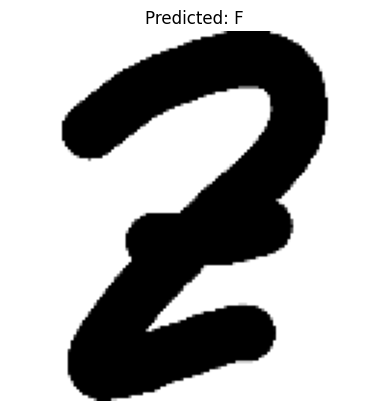

In [13]:
import glob
import os
import matplotlib as plt
import cv2
from sklearn.preprocessing import LabelEncoder
import string

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from hyperparameter import *
from models import *
from dataset import *
from defaults import *

test_images_folder = 'test_images_characters/Test'
test_images_paths = glob.glob(os.path.join(test_images_folder, '*.png'))



# Plot test images and predict their classes
saved_model_path = os.path.join(model_name, f"{model_name}.pth")
model = chosen_model
model.load_state_dict(torch.load(saved_model_path))
model.eval()




current_directory = os.getcwd()#
x = 0
for image_path in test_images_paths:
    try:
        # Read and process the image as in the dataset
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        cropped_img = crop_image(img)
        squared_img = make_square_image(cropped_img)
        # padded_img = make_padding(squared_img)
        # Apply the specified transformations
        transform = transforms.Compose([transforms.ToTensor()])
        input_image = transform(squared_img).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(input_image)
        predicted_class = torch.argmax(output).item()
        predicted_category = CATEGORIES[predicted_class]
        # Plot the test image
        plt.imshow(input_image[0][0].cpu().numpy(), cmap='gray')
        plt.title(f'Predicted: {predicted_category}')
        plt.axis('off')
        save_path = f'plots/prediction/characters/{architecture}'
        os.makedirs(save_path, exist_ok=True)
        file_name = f"prediction_{architecture}_{x}.png"
        file_path = os.path.join(save_path, file_name)
        plt.savefig(file_path)
        # plt.show()
    except:
        print("Error processing file: " + image_path)

    x+=1
    

# except Exception as e:
#     print(f"Error: {e}")
        






# Confusion Matrix

Erstellt eine Confusion Matrix mit meinem Modell

In [2]:
import glob
import os
import re
import sklearn
import cv2
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from hyperparameter import *
from models import *
from dataset import *
from defaults import *


test_images_folder = 'test_images_characters/all' # test_images_characters/Test for small number of images
test_images_paths = glob.glob(os.path.join(test_images_folder, '*.png'))
target_size = 128
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


saved_model_path = os.path.join(model_name, f"{model_name}.pth")

# Initialize the model and load the state dictionary
model = chosen_model
model.load_state_dict(torch.load(saved_model_path, map_location=device))
model.eval()


def number_to_character(number_str):
    # Convert the string number to an integer
    number = int(number_str)

    # Define the range for each set of characters
    digits_range = range(1, 11)
    uppercase_range = range(11, 37)
    lowercase_range = range(37, 63)

    # Determine the corresponding character
    if number in digits_range:
        char = str(number - 1)
    elif number in uppercase_range:
        char = chr(ord('A') + number - 11)
    elif number in lowercase_range:
        char = chr(ord('a') + number - 37)
    else:
        char = "Invalid"

    return char

# Initialize lists for true and predicted labels
true_labels = []
predicted_labels = []

# Loop over test images
for image_path in test_images_paths:
    try:
        # Read and process the image as in the dataset
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (target_size, target_size))

        cropped_img = crop_image(img)
        squared_img = make_square_image(cropped_img)
        transform = transforms.Compose([transforms.ToTensor()])
        input_image = transform(squared_img).unsqueeze(0).to(device)

        # Get the true label from the file name
        # true_category = image_path.split('-')[0][3:]  # Extract characters after 'img' and before '-'
        match = re.search(r'img(\d+)-', image_path)

        if match:
            true_category = match.group(1)
            true_category_char = number_to_character(true_category)
            if true_category_char != "Invalid":
                true_labels.append(true_category_char)
            else: 
                print("Invalid found: " + image_path + " true_category: " + true_category)

        # Predict the label using the model
        with torch.no_grad():
            output = model(input_image)
        predicted_class = torch.argmax(output).item()
        predicted_category = CATEGORIES[predicted_class]
        predicted_labels.append(predicted_category)

    except Exception as e:
        print(f"Error processing file: {image_path}, {e}")



unique_true_labels = np.unique(true_labels)
unique_predicted_labels = np.unique(predicted_labels)


# # Create a confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CATEGORIES.values(), yticklabels=CATEGORIES.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix - {architecture} - uppercase & lowercase')
save_path = 'plots/analysis'
os.makedirs(save_path, exist_ok=True)
file_name = f"confusionmatrix_{architecture}_original.png"
file_path = os.path.join(save_path, file_name)
plt.savefig(file_path)
# plt.show()

# Print the classification report
print(classification_report(true_labels, predicted_labels, target_names=CATEGORIES.values()))
        

# Buchstaben in Wörtern erkennen (ohne i-Punkt)

Speichert Bilder und deren Prediction mit Wörtern, allerdings ohne genauere Betrachtung des i-Punktes

In [ ]:
import Levenshtein
import cv2
import os
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from hyperparameter import *
from models import *
from dataset import *
from defaults import *


def find_connected_components_within_box(cropped_image, brightness_threshold=200):
    # Anwenden des Schwellenwerts für helle Pixel
    _, binary_image = cv2.threshold(cropped_image, brightness_threshold, 255, cv2.THRESH_BINARY_INV)

    # Finde die verbundenen Komponenten
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image, connectivity=8)

    # Erstellen einer Liste für Begrenzungsrahmen
    bounding_boxes = []


    # Initialize variables to keep track of the maximum area and its corresponding bounding box
    max_area = 0
    max_area_box = None
    # Iteriere über die gefundenen Regionen und füge Begrenzungsrahmen hinzu
    for i in range(1, num_labels):
        x, y, w, h, area = stats[i]
        bounding_boxes.append([x, y, x + w, y + h])
        
        # Check if the current area is larger than the maximum area
        if area > max_area:
            max_area = area
            max_area_box = (x, y, x + w, y + h)

    return bounding_boxes


# Funktion zum Konvertieren eines Buchstabens von einem Modell-Prediction-Index
def index_to_character(index):
    return list(CATEGORIES.values())[index]

# Funktion zum Vorverarbeiten des Bildes für die Modellvorhersage
def preprocess_image(image):
    image = make_square_image(image)
    transform = transforms.Compose([transforms.ToTensor()])
    image = transform(image).unsqueeze(0)
    return image

def sort_bounding_boxes(bounding_boxes):
    # Sortiere die Bounding Boxes nach der linken Kante (x_min)
    return sorted(bounding_boxes, key=lambda box: box[0])

def predict_characters_from_boxes(bounding_boxes, input_image, model):
    # Iteriere über die sortierten Bounding Boxes und führe die Vorhersage durch
    predicted_characters = []
    for i, box in enumerate(bounding_boxes):
        x_min, y_min, x_max, y_max = box

        # Schneide die Region aus
        cropped_region = input_image[y_min:y_max, x_min:x_max]

        # Vorverarbeite das Bild für die Modellvorhersage
        cropped_region = preprocess_image(cropped_region)

        # Setze das Modell in den Evaluationsmodus
        model.eval()

        # Führe eine Vorhersage durch
        with torch.no_grad():
            output = model(cropped_region)

        # Bestimme die vorhergesagte Klasse
        predicted_class = torch.argmax(output).item()

        # Konvertiere den Index in den entsprechenden Buchstaben
        predicted_character = index_to_character(predicted_class)

        # print(f"Für die Bounding Box {i+1} wurde der Buchstabe {predicted_character} erkannt.")
        predicted_characters.append(predicted_character)
    return predicted_characters

def calculate_similarity(word1, word2):
    distance = Levenshtein.distance(word1, word2)
    max_length = max(len(word1), len(word2))
    similarity = 1 - (distance / max_length)
    return similarity

# Ordnerpfad
folder_path = "test_images_words"
similarity_original_total = 0
total_images = 0

for filename in os.listdir(folder_path):

    if filename.endswith(".png"):
        # Bildpfad
        image_path = os.path.join(folder_path, filename)

        # Lade das Bild in Graustufen
        input_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        # Finde die verbundenen Komponenten für dunkle Flächen
        bounding_boxes = find_connected_components_within_box(input_image)

        # Sortiere die Bounding Boxes nach der linken Kante
        sorted_boxes = sort_bounding_boxes(bounding_boxes)

        # alle Bounding Boxes anzeigen
        plt.figure(figsize=(8, 8))
        plt.imshow(input_image, cmap='gray')

        for box in sorted_boxes:
            x_min, y_min, x_max, y_max = box
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=False, color='red', linewidth=2)
            plt.gca().add_patch(rect)

        predicted_characters = predict_characters_from_boxes(sorted_boxes, input_image, chosen_model)
        # Berechne die Genauigkeit und füge sie zur Gesamtgenauigkeit hinzu
        predicted_word = ''.join(predicted_characters)
        reference_word = filename.split("_")[1].split(".")[0]
        similarity_original = round(calculate_similarity(reference_word, predicted_word), 2)
        similarity_original_total += similarity_original
        total_images += 1

        plt.title("Predicted: " + ''.join(predicted_characters) + 
                  f"\nLevenshtein similarity: {similarity_original}")
        save_path = 'plots/prediction/words_without_i'
        os.makedirs(save_path, exist_ok=True)
        file_name = f"x_{reference_word}.png"
        file_path = os.path.join(save_path, file_name)
        plt.savefig(file_path)
        # plt.show()


print(f"Total similarity: {similarity_original_total / total_images}")


# Buchstaben in Wörtern erkennen mit i-Punkt

Speichert Bilder und deren Prediction mit Wörtern, mit Betrachtung des i-Punktes

In [ ]:
import cv2
import os
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from hyperparameter import *
from models import *
from dataset import *
from defaults import *
import Levenshtein



def find_connected_components_within_box(cropped_image, brightness_threshold=200):
    # Anwenden des Schwellenwerts für helle Pixel
    _, binary_image = cv2.threshold(cropped_image, brightness_threshold, 255, cv2.THRESH_BINARY_INV)

    # Finde die verbundenen Komponenten
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image, connectivity=8)

    # Erstellen einer Liste für Begrenzungsrahmen
    bounding_boxes = []


    # Initialize variables to keep track of the maximum area and its corresponding bounding box
    max_area = 0
    max_area_box = None
    # Iteriere über die gefundenen Regionen und füge Begrenzungsrahmen hinzu
    for i in range(1, num_labels):
        x, y, w, h, area = stats[i]
        bounding_boxes.append([x, y, x + w, y + h])
        
        # Check if the current area is larger than the maximum area
        if area > max_area:
            max_area = area
            max_area_box = (x, y, x + w, y + h)
        

    i_elements = [] # indices of i elements in bounding box
    # finde i-Punkt und strecke i-Strich nach oben
    for i in range(1, num_labels):
        x, y, w, h, area = stats[i]
        # print(f"w * h = {w} * {h} = {w*h}")
        if area < 0.1*max_area:
            # print("index " + str(i) + ": Character is probably an 'i': " + str(area))
            nearest_x = 100000
            nearest_x_index = 100000
            # wahrwscheinlich i-Punkt
            # suche den i-Strich zum i-Punkt
            for n in range(1, num_labels):
                x2, y2, w2, h2, area2 = stats[n]
                # print(f"index {n}: x2-x = {x2} - {x} = {x2-x}")
                if abs(x2-x) < nearest_x and n != i:
                    # print(f"{abs(x2-x)} is smaller than nearest_x = {nearest_x}. nearest_x will be {abs(x2-x)}. nearest_x_index will be {n-1}")
                    nearest_x_index = n-1
                    nearest_x = abs(x2-x)
            bounding_boxes[nearest_x_index][1] = y # erweitere i-Strich um i-Punkt nach oben

            if x < bounding_boxes[nearest_x_index][0]:
                bounding_boxes[nearest_x_index][0] = x # erweitere i nach links, wenn Punkt links neben Strich
            # print("x: " + str(x))
            # print("nearest_x: " + str(nearest_x))

            if x+w > bounding_boxes[nearest_x_index][2]:
                bounding_boxes[nearest_x_index][2] = x + w # erweitere i nach rechts, wenn Punkt rechts neben Strich


            # print(f"nearest_x_index: {nearest_x_index}")
            i_elements.append(i)
    
    i_elements_desc = sorted(i_elements, reverse=True)
    for i in i_elements_desc:
        x, y, x_max, y_max = box
        width = x_max - x
        height = y_max - y
        area = width * height
        bounding_boxes.pop(i-1)


    return bounding_boxes

# Funktion zum Konvertieren eines Buchstabens von einem Modell-Prediction-Index
def index_to_character(index):
    return list(CATEGORIES.values())[index]

# Funktion zum Vorverarbeiten des Bildes für die Modellvorhersage
def preprocess_image(image):
    image = make_square_image(image)
    transform = transforms.Compose([transforms.ToTensor()])
    image = transform(image).unsqueeze(0)
    return image

def sort_bounding_boxes(bounding_boxes):
    # Sortiere die Bounding Boxes nach der linken Kante (x_min)
    return sorted(bounding_boxes, key=lambda box: box[0])

def predict_characters_from_boxes(bounding_boxes, input_image, model):
    # Iteriere über die sortierten Bounding Boxes und führe die Vorhersage durch
    predicted_characters = []
    for i, box in enumerate(bounding_boxes):
        x_min, y_min, x_max, y_max = box

        # Schneide die Region aus
        cropped_region = input_image[y_min:y_max, x_min:x_max]

        # Vorverarbeite das Bild für die Modellvorhersage
        cropped_region = preprocess_image(cropped_region)
        
        # Setze das Modell in den Evaluationsmodus
        model.eval()

        # Führe eine Vorhersage durch
        with torch.no_grad():
            output = model(cropped_region)

        # Bestimme die vorhergesagte Klasse
        predicted_class = torch.argmax(output).item()

        # Konvertiere den Index in den entsprechenden Buchstaben
        predicted_character = index_to_character(predicted_class)

        # print(f"Für die Bounding Box {i+1} wurde der Buchstabe {predicted_character} erkannt.")
        predicted_characters.append(predicted_character)
    return predicted_characters

def calculate_similarity(word1, word2):
    distance = Levenshtein.distance(word1, word2)
    max_length = max(len(word1), len(word2))
    similarity = 1 - (distance / max_length)
    return similarity

# Ordnerpfad
folder_path = "test_images_words"
similarity_original_total = 0
total_images = 0

for filename in os.listdir(folder_path):

    if filename.endswith(".png"):
        # Bildpfad
        image_path = os.path.join(folder_path, filename)

        # Lade das Bild in Graustufen
        input_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        # Finde die verbundenen Komponenten für dunkle Flächen
        bounding_boxes = find_connected_components_within_box(input_image)

        # Sortiere die Bounding Boxes nach der linken Kante
        sorted_boxes = sort_bounding_boxes(bounding_boxes)

        # alle Bounding Boxes anzeigen
        plt.figure(figsize=(8, 8))
        plt.imshow(input_image, cmap='gray')

        for box in sorted_boxes:
            x_min, y_min, x_max, y_max = box
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=False, color='red', linewidth=2)
            plt.gca().add_patch(rect)

        predicted_characters = predict_characters_from_boxes(sorted_boxes, input_image, chosen_model)

        


        # Berechne die Genauigkeit und füge sie zur Gesamtgenauigkeit hinzu
        predicted_word = ''.join(predicted_characters)
        reference_word = filename.split("_")[1].split(".")[0]
        similarity_original = round(calculate_similarity(reference_word, predicted_word), 2)
        similarity_original_total += similarity_original
        total_images += 1

        plt.title("Predicted: " + ''.join(predicted_characters) +  
                  f"\nLevenshtein similarity: {similarity_original}")
        save_path = 'plots/prediction/words_with_i'
        os.makedirs(save_path, exist_ok=True)
        file_name = f"x_{reference_word}.png"
        file_path = os.path.join(save_path, file_name)
        plt.savefig(file_path)
        # plt.show()


print(f"Total similarity original: {similarity_original_total / total_images}")


# Pytesseract Confusion Matrix

Erstellt eine Confusion Matrix mit Tesseract

test_images_characters/all\img001-001.png
Q Q
test_images_characters/all\img001-002.png
O O
test_images_characters/all\img001-003.png
() else
test_images_characters/all\img001-004.png
0 0
test_images_characters/all\img001-005.png
O O
test_images_characters/all\img001-006.png
 else
test_images_characters/all\img001-007.png
 else
test_images_characters/all\img001-008.png
QO else
test_images_characters/all\img001-009.png
© else
test_images_characters/all\img001-010.png
O O
test_images_characters/all\img001-011.png
o o
test_images_characters/all\img001-012.png
O O
test_images_characters/all\img001-013.png
0 0
test_images_characters/all\img001-014.png
O O
test_images_characters/all\img001-015.png
O O
test_images_characters/all\img001-016.png
O O
test_images_characters/all\img001-017.png
O O
test_images_characters/all\img001-018.png
0 0
test_images_characters/all\img001-019.png
O O
test_images_characters/all\img001-020.png
 else
test_images_characters/all\img001-021.png
C C
test_images_chara

d:\BHT\Master\OCR\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\BHT\Master\OCR\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\BHT\Master\OCR\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.38      0.09      0.15        55
           1       0.77      0.36      0.49        55
           2       0.43      0.33      0.37        55
           3       0.68      0.58      0.63        55
           4       0.31      0.31      0.31        55
           5       0.58      0.40      0.47        55
           6       0.67      0.56      0.61        55
           7       0.61      0.40      0.48        55
           8       1.00      0.07      0.14        55
           9       0.40      0.04      0.07        55
           A       0.52      0.76      0.62        55
           B       1.00      0.33      0.49        55
           C       0.42      0.89      0.57        55
           D       0.80      0.78      0.79        55
           E       0.93      0.75      0.83        55
           F       0.93      0.47      0.63        55
           G       0.64      0.64      0.64        55
           H       1.00    

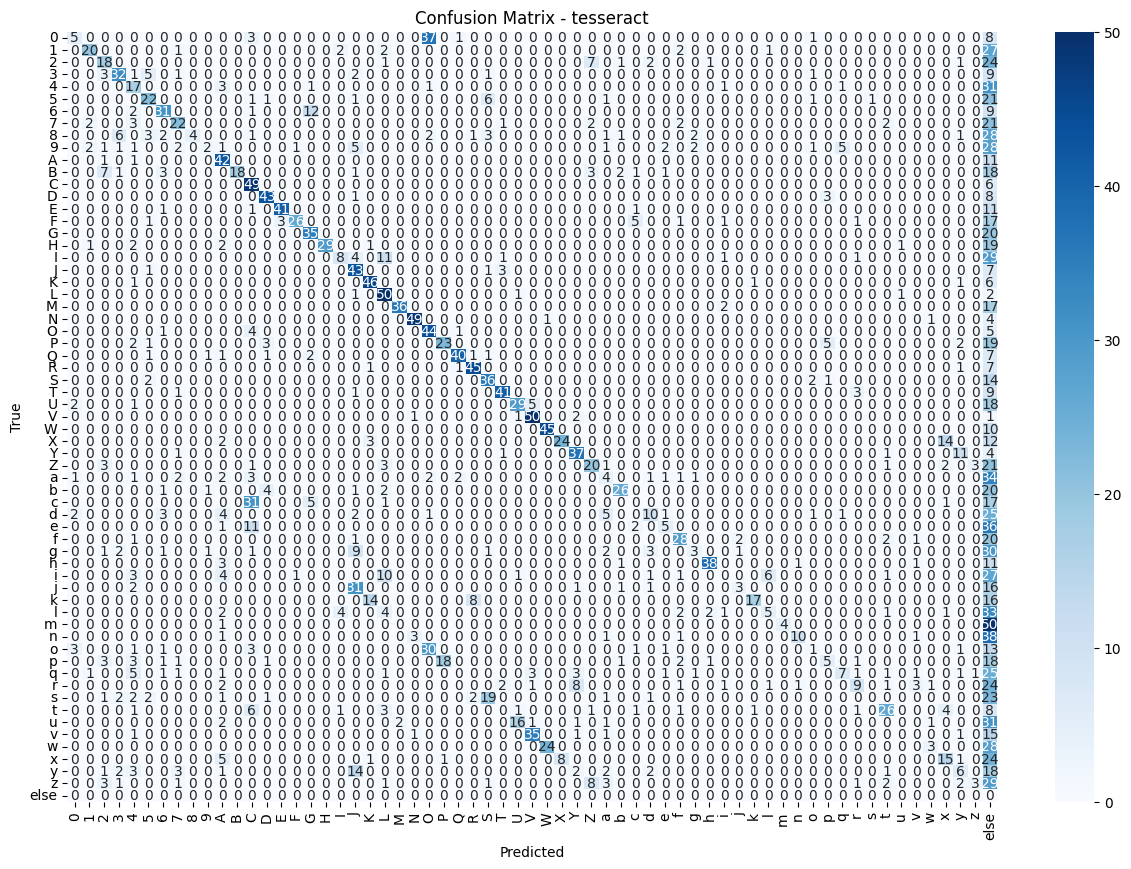

In [10]:
import glob
import os
import re
import cv2
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pytesseract
from pytesseract import Output
from hyperparameter import *
from models import *
from dataset import *
from defaults import *

test_images_folder = 'test_images_characters/all' # test_images_characters/Test for small number of images
test_images_paths = glob.glob(os.path.join(test_images_folder, '*.png'))
CATEGORIES_TESSERACT = CATEGORIES
CATEGORIES_TESSERACT['else'] = 'else'


def number_to_character(number_str):
    # Convert the string number to an integer
    number = int(number_str)

    # Define the range for each set of characters
    digits_range = range(1, 11)
    uppercase_range = range(11, 37)
    lowercase_range = range(37, 63)

    # Determine the corresponding character
    if number in digits_range:
        char = str(number - 1)
    elif number in uppercase_range:
        char = chr(ord('A') + number - 11)
    elif number in lowercase_range:
        char = chr(ord('a') + number - 37)
    else:
        char = "Invalid"

    return char


# Initialize lists for true and predicted labels
true_labels = []
predicted_labels = []


# Loop over test images
for image_path in test_images_paths:
    try:
        # Read and process the image as in the dataset
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        match = re.search(r'img(\d+)-', image_path)
        if match:
            true_category = match.group(1)
            true_category_char = number_to_character(true_category)
            if true_category_char != "Invalid":
                true_labels.append(true_category_char)
            else: 
                print("Invalid found: " + image_path + " true_category: " + true_category)

        # Predict the label using pytesseract
        predicted_text = pytesseract.image_to_string(img, config='--psm 10 --oem 3', output_type=Output.STRING)
        predicted_category = predicted_text.strip()

        # Add to "else" category if not in CATEGORIES
        if predicted_category in CATEGORIES_TESSERACT.values():
            predicted_labels.append(predicted_category)
        else:
            predicted_labels.append('else')

    except Exception as e:
        print(f"Error processing file: {image_path}, {e}")

# Get the unique labels from true and predicted labels
unique_labels = sorted(set(true_labels + predicted_labels))
unique_labels = sorted(unique_labels, key=lambda x: x if x != 'else' else 'zzz')


# Create a confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=unique_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - tesseract')
save_path = 'plots/analysis'
os.makedirs(save_path, exist_ok=True)
file_name = f"confusionmatrix_tesseract.png"
file_path = os.path.join(save_path, file_name)
plt.savefig(file_path)

# Print the classification report
print(classification_report(true_labels, predicted_labels, target_names=unique_labels))


# Tesseract Wörter erkennen

Speichert Bilder und deren Prediction mit Wörtern mit Tesseract

In [ ]:
import cv2
import os
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from hyperparameter import *
from models import *
from dataset import *
from defaults import *


def number_to_character(number_str):
    # Convert the string number to an integer
    number = int(number_str)

    # Define the range for each set of characters
    digits_range = range(1, 11)
    uppercase_range = range(11, 37)
    lowercase_range = range(37, 63)

    # Determine the corresponding character
    if number in digits_range:
        char = str(number - 1)
    elif number in uppercase_range:
        char = chr(ord('A') + number - 11)
    elif number in lowercase_range:
        char = chr(ord('a') + number - 37)
    else:
        char = "Invalid"

    return char

def find_connected_components_within_box(cropped_image, brightness_threshold=200):
    # Anwenden des Schwellenwerts für helle Pixel
    _, binary_image = cv2.threshold(cropped_image, brightness_threshold, 255, cv2.THRESH_BINARY_INV)

    # Finde die verbundenen Komponenten
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image, connectivity=8)

    # Erstellen einer Liste für Begrenzungsrahmen
    bounding_boxes = []


    # Initialize variables to keep track of the maximum area and its corresponding bounding box
    max_area = 0
    max_area_box = None
    # Iteriere über die gefundenen Regionen und füge Begrenzungsrahmen hinzu
    for i in range(1, num_labels):
        x, y, w, h, area = stats[i]
        bounding_boxes.append([x, y, x + w, y + h])
        
        # Check if the current area is larger than the maximum area
        if area > max_area:
            max_area = area
            max_area_box = (x, y, x + w, y + h)
        

    i_elements = [] # indices of i elements in bounding box
    # finde i-Punkt und strecke i-Strich nach oben
    for i in range(1, num_labels):
        x, y, w, h, area = stats[i]
        # print(f"w * h = {w} * {h} = {w*h}")
        if area < 0.1*max_area:
            # print("index " + str(i) + ": Character is probably an 'i': " + str(area))
            nearest_x = 100000
            nearest_x_index = 100000
            # wahrwscheinlich i-Punkt
            # suche den i-Strich zum i-Punkt
            for n in range(1, num_labels):
                x2, y2, w2, h2, area2 = stats[n]
                # print(f"index {n}: x2-x = {x2} - {x} = {x2-x}")
                if abs(x2-x) < nearest_x and n != i:
                    # print(f"{abs(x2-x)} is smaller than nearest_x = {nearest_x}. nearest_x will be {abs(x2-x)}. nearest_x_index will be {n-1}")
                    nearest_x_index = n-1
                    nearest_x = abs(x2-x)
            bounding_boxes[nearest_x_index][1] = y # erweitere i-Strich um i-Punkt nach oben
            # print(f"nearest_x_index: {nearest_x_index}")
            i_elements.append(i)
    
    i_elements_desc = sorted(i_elements, reverse=True)
    for i in i_elements_desc:
        x, y, x_max, y_max = box
        width = x_max - x
        height = y_max - y
        area = width * height
        bounding_boxes.pop(i-1)


    return bounding_boxes

# Funktion zum Konvertieren eines Buchstabens von einem Modell-Prediction-Index
def index_to_character(index):
    return list(CATEGORIES.values())[index]

# Funktion zum Vorverarbeiten des Bildes für die Modellvorhersage
def preprocess_image(image):
    image = make_square_image(image)
    transform = transforms.Compose([transforms.ToTensor()])
    image = transform(image).unsqueeze(0)
    return image

def sort_bounding_boxes(bounding_boxes):
    # Sortiere die Bounding Boxes nach der linken Kante (x_min)
    return sorted(bounding_boxes, key=lambda box: box[0])

def predict_characters_from_boxes(bounding_boxes, input_image, model):
    # Iteriere über die sortierten Bounding Boxes und führe die Vorhersage durch
    predicted_characters = []
    for i, box in enumerate(bounding_boxes):
        x_min, y_min, x_max, y_max = box

        # Schneide die Region aus
        cropped_region = input_image[y_min:y_max, x_min:x_max]

        # Vorverarbeite das Bild für die Modellvorhersage
        cropped_region = preprocess_image(cropped_region)
        
        # Setze das Modell in den Evaluationsmodus
        model.eval()

        # Führe eine Vorhersage durch
        with torch.no_grad():
            output = model(cropped_region)

        # Bestimme die vorhergesagte Klasse
        predicted_class = torch.argmax(output).item()

        # Konvertiere den Index in den entsprechenden Buchstaben
        predicted_character = index_to_character(predicted_class)

        # print(f"Für die Bounding Box {i+1} wurde der Buchstabe {predicted_character} erkannt.")
        predicted_characters.append(predicted_character)
    return predicted_characters

def calculate_similarity(word1, word2):
    distance = Levenshtein.distance(word1, word2)
    max_length = max(len(word1), len(word2))
    similarity = 1 - (distance / max_length)
    return similarity

# Ordnerpfad
folder_path = "test_images_words"
similarity_original_total = 0
similarity_lowercase_total = 0
total_images = 0


for filename in os.listdir(folder_path):

    if filename.endswith(".png"):
        # Bildpfad
        image_path = os.path.join(folder_path, filename)

        # Lade das Bild in Graustufen
        input_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        

        predicted_word = pytesseract.image_to_string(input_image, config='--psm 10 --oem 3', output_type=Output.STRING)


        # Berechne die Genauigkeit und füge sie zur Gesamtgenauigkeit hinzu
        reference_word = filename.split("_")[1].split(".")[0]

        # Berechne die Genauigkeit und füge sie zur Gesamtgenauigkeit hinzu
        similarity_original = round(calculate_similarity(reference_word, predicted_word), 2)
        similarity_original_total += similarity_original
        total_images += 1


        
        plt.figure(figsize=(8, 8))
        plt.imshow(input_image, cmap='gray')
        plt.title("Predicted: " + predicted_word + 
                  f"\nLevenshtein similarity: {similarity_original}")
        save_path = 'plots/prediction/words_tesseract'
        os.makedirs(save_path, exist_ok=True)
        file_name = f"x_{predicted_category}.png"
        file_path = os.path.join(save_path, file_name)
        plt.savefig(file_path)
        # plt.show()

print(f"Total similarity: {similarity_original_total / total_images}")
